<a href="https://colab.research.google.com/github/GaryGu12138/AI4EO-FInal-Project/blob/main/cnn_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Vegetation Detection Model Training
#### 1.1 Dataset Preparation

In [ ]:
import kagglehub

# Download training data
path = kagglehub.dataset_download("balraj98/deepglobe-land-cover-classification-dataset")


100%|██████████| 2.74G/2.74G [00:21<00:00, 139MB/s]

Extracting files...


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

###### read class_dict
class_dict_path = os.path.join(path, "class_dict.csv")
class_dict = pd.read_csv(class_dict_path)
rgb_to_class = {}
for index, row in class_dict.iterrows():
    rgb_to_class[(row['r'], row['g'], row['b'])] = row['name']

# defining vegetation classes
vegetation_classes = {'agriculture_land', 'rangeland', 'forest_land'}
non_vegetation_classes = {'urban_land', 'water', 'barren_land', 'unknown'}


###### read training data
train_folder = os.path.join(path, "train")
satellite_images = []
mask_images = []

sat_files = [f for f in os.listdir(train_folder) if f.endswith("_sat.jpg")]
max_files = 100
count = 0

for sat_file in sat_files:
    if count >= max_files:
        break
    # read satellite image
    sat_path = os.path.join(train_folder, sat_file)
    # sat_image = np.array(Image.open(sat_path), dtype=np.float32) / 255.0  # Normalize to [0, 1]
    sat_image = np.array(Image.open(sat_path))
    satellite_images.append(sat_image)

    # read label image
    mask_file = sat_file.replace("_sat.jpg", "_mask.png")
    mask_path = os.path.join(train_folder, mask_file)
    mask_image = np.array(Image.open(mask_path))

    # mapping RGB values to category labels
    mask_labels = np.zeros(mask_image.shape[:2], dtype=np.uint8)
    for rgb, class_name in rgb_to_class.items():
        if class_name in vegetation_classes:
            mask_labels[(mask_image == rgb).all(axis=2)] = 1  # vegetation
        elif class_name in non_vegetation_classes:
            mask_labels[(mask_image == rgb).all(axis=2)] = 0  # non-vegetation
    mask_images.append(mask_labels)
    count += 1

satellite_images = np.array(satellite_images)
mask_images = np.array(mask_images)

###### dividing data into training, validation and testing set
X_train, X_temp, y_train, y_temp = train_test_split(satellite_images, mask_images, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


RGB to Class Mapping:
{(0, 255, 255): 'urban_land', (255, 255, 0): 'agriculture_land', (255, 0, 255): 'rangeland', (0, 255, 0): 'forest_land', (0, 0, 255): 'water', (255, 255, 255): 'barren_land', (0, 0, 0): 'unknown'}
Satellite Images Shape: (100, 2448, 2448, 3)
Mask Labels Shape: (100, 2448, 2448)
Training Set Shape: (60, 2448, 2448, 3) (60, 2448, 2448)
Validation Set Shape: (20, 2448, 2448, 3) (20, 2448, 2448)
Testing Set Shape: (20, 2448, 2448, 3) (20, 2448, 2448)


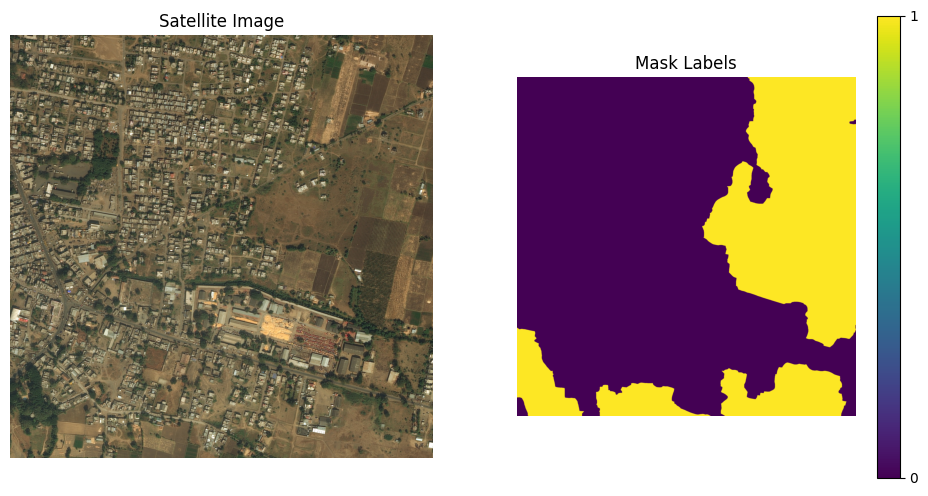

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

###### Show a random image and label
sat_image = X_train[0]
mask_labels = y_train[0]

plt.figure(figsize=(12, 6))

# satellite image
plt.subplot(1, 2, 1)
plt.imshow(sat_image)
plt.title("Satellite Image")
plt.axis('off')

# labels
plt.subplot(1, 2, 2)
plt.imshow(mask_labels, cmap='viridis')
plt.title("Mask Labels")
plt.axis('off')

unique_labels = np.unique(mask_labels)
cbar = plt.colorbar(ticks=unique_labels)
cbar.set_ticklabels(unique_labels)

plt.show()

#### 1.2 Model Training

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import UpSampling2D


def build_cnn_model(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

    # Upsampling layer to restore original resolution
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))

    # Output layer
    model.add(Conv2D(1, (1, 1), activation='sigmoid', padding='same'))

    return model

# Get input shape and number of classes
input_shape = X_train.shape[1:]  # (H, W, 3)
num_classes = len(np.unique(y_train))  # assuming y_train are integer labels

# Build the model
model = build_cnn_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 2448, 2448, 8)  │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1224, 1224, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 1224, 1224, 16) │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 612, 612, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 612, 612, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 1224, 1224, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 1224, 1224, 16) │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 2448, 2448, 16) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 2448, 2448, 1)  │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,673 (41.69 KB)

 Trainable params: 10,673 (41.69 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

In [ ]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 468s 118s/step - accuracy: 0.5255 - loss: 1.8806 - val_accuracy: 0.7757 - val_loss: 0.6848
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 465s 118s/step - accuracy: 0.6627 - loss: 0.7261 - val_accuracy: 0.6436 - val_loss: 0.6842
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 469s 118s/step - accuracy: 0.6948 - loss: 0.6686 - val_accuracy: 0.7983 - val_loss: 0.5989
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 465s 117s/step - accuracy: 0.7972 - loss: 0.6324 - val_accuracy: 0.7790 - val_loss: 0.5917
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 470s 119s/step - accuracy: 0.7299 - loss: 0.5943 - val_accuracy: 0.6087 - val_loss: 0.6699
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 463s 117s/step - accuracy: 0.7170 - loss: 0.5982 - val_accuracy: 0.7930 - val_loss: 0.5993
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 466s 117s/step - accuracy: 0.7984 - loss: 0.5663 - val_accuracy: 0.7879 - val_loss: 0.5941
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 464s 117s/step - accuracy: 0.7304 - loss: 0.5994 - val_accuracy: 0.5779 - v

#### 1.3 Performance Assessment

1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.8265 - loss: 0.5600
Test Loss: 0.5600
Test Accuracy: 0.8265


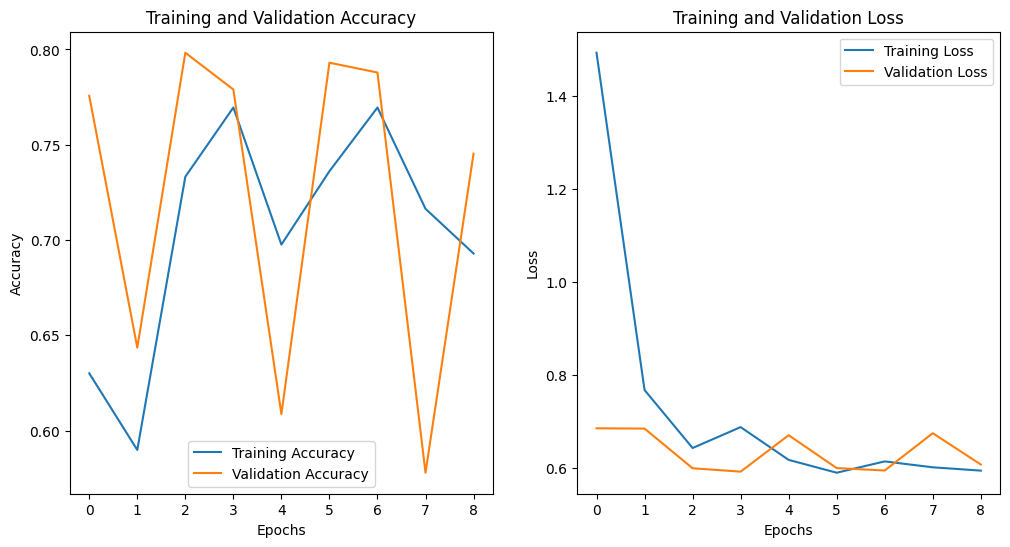

Model saved successfully as 'pixel_classification_model.h5'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy/loss curves
plt.figure(figsize=(12, 6))

# Plot accuracy curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Save the model
model.save("pixel_classification_model.h5")
print("Model saved successfully as 'pixel_classification_model.h5'")